In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://arxiv.org/abs/1703.10593

# Imports

In [ ]:
import torch
from PIL import Image
import sys
sys.path.append('/content/drive/MyDrive/CycleGANSim2Real/Sim2Real')

import os
from torch.utils.data import Dataset
from torchvision.transforms.functional import crop
import numpy as np

import sys
import torchvision.transforms as tf
#import albumentations as atf
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import RandomVerticalFlip
from tqdm import tqdm
from torchvision.utils import save_image
import warnings
warnings.filterwarnings("ignore")
device= 'cuda' if torch.cuda.is_available() else 'cpu'


# Hyperparameters

In [1]:

root_img="img"
saved_models="saved_models"

model_version=1
n_epochs=50
lr=0.0002
beta1=0.5
beta2=0.99
lambda_cycle = 10
lambda_identity = 0.2


# DataLoaders

In [ ]:
class SimRealDataset(Dataset):
    def __init__(self, root_img, transform = None):
        super().__init__()
        self.root_img = root_img
       # self.hflipper = RandomVerticalFlip(p=0.5)
        self.transform = transform

        self.root_imgs = os.listdir(root_img)
        self.transforms = tf.Compose(
                          [
                              tf.ToTensor(),
                              tf.ToPILImage(),
                              RandomVerticalFlip(p=0.5)

                          ]   )


    def __len__(self):
        return len(self.root_imgs)

    def __getitem__(self, item):
        simreal_img = self.root_imgs[item % len(self.root_imgs)]


        simpeal_path = os.path.join(self.root_img, simreal_img)

        simreal_img =np.array(Image.open(simpeal_path).convert("RGB"))
        h, w, _ = simreal_img.shape
        # переворачиваем вертикально картинку до того, как поделим её на 2 части
        simreal_img = self.transforms(simreal_img)
       # simreal_img = self.hflipper(simreal_img)
        sim_img = crop(simreal_img,   0, w / 2, h, w / 2)
        sim_img_tensor = tf.ToTensor()(sim_img)

        real_img = crop(simreal_img, 0, 0, h, w / 2)

        real_img_tensor = tf.ToTensor()(real_img)

        if self.transform:

            sim_img_tensor = self.transform(sim_img_tensor)
            real_img_tensor = self.transform(real_img_tensor)

        return sim_img_tensor, real_img_tensor




In [ ]:
transforms = tf.Compose(
    [
       tf.Resize((400, 600))

    ]
)


root_path = '/content/drive/MyDrive/CycleGANSim2Real/' + root_img
train_dataset = SimRealDataset(  root_path, transform =transforms)
#test_dataset= SimRealDataset( root_apples = root_path+'testA', root_oranges = root_path+'testB', transform =None)

train_loader =DataLoader(train_dataset, batch_size=1,shuffle=True)
#test_loader =DataLoader(test_dataset, batch_size=4,shuffle=False)
sim_img_tensor, real_img_tensor = next(iter(train_loader))

In [ ]:

print("Images shape = ", sim_img_tensor[0].shape)
f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].imshow(sim_img_tensor[0].permute(1, 2, 0))
axarr[1].imshow(real_img_tensor[0].permute(1, 2, 0))

plt.show()

# Model of CycleGAN

Implementation of:

https://arxiv.org/abs/1703.10593

## Discriminator

In [ ]:
# create blochk for discriminator
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel, stride, padding, bias = True, padding_mode="reflect" ),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):

        return self.block(x)




class Discriminator(nn.Module):
    def __init__(self, in_channels = 3, features = [16, 32, 64, 128, 256]):
        super().__init__()
        self.initialBlock = nn.Sequential(

            nn.Conv2d(in_channels, features[0], 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)

        )
        layers = []
        in_channels = features[0]
        for channels in features[1:]:
            layers.append( Block(in_channels, channels, 4, 2, 1)    )
            in_channels = channels
        layers.append(nn.Conv2d(in_channels, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initialBlock(x)
        return torch.sigmoid(self.model(x))

In [ ]:
print(sim_img_tensor[0].shape)
d = Discriminator()
d(sim_img_tensor[0]).shape

torch.Size([3, 400, 600])


torch.Size([1, 11, 17])

## Generator

In [ ]:

class ConvBlock(nn.Module):
    def __init__(self,in_ch, out_ch, is_up = False, identity = False, **kwargs ):
        super().__init__()
        self.conv = nn.Sequential(

            nn.Conv2d(in_ch, out_ch, padding_mode = "reflect" , **kwargs) if not is_up else nn.ConvTranspose2d(in_ch, out_ch,  **kwargs),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(0.2) if not identity else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)




class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.resBlock = nn.Sequential(

            ConvBlock(channels, channels, kernel_size = 3, stride = 1, padding = 1),
            ConvBlock(channels, channels, identity = True, kernel_size = 3, stride = 1, padding = 1)

        )

    def forward(self, x):
        return self.resBlock(x) + x


class Generator(nn.Module):
    def __init__(self, img_channels=3, channels = 32, num_residuals = 9):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(img_channels,channels, kernel_size= 7 ,padding =  3, stride= 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),

        )

        self.conv = nn.ModuleList([
            ConvBlock(channels, channels*2, kernel_size= 3 ,padding = 1, stride= 2),
            ConvBlock(channels*2, channels*4, kernel_size= 3 ,padding = 1, stride= 2)
        ])

        self.residuals_blocks = nn.Sequential(
            *[ResBlock(channels*4) for _ in range(num_residuals)]
        )

        self.up_conv = nn.ModuleList(
            [
                ConvBlock(channels*4, channels * 2, is_up=True, kernel_size=3, padding=1, stride=2, output_padding = 1),
                ConvBlock(channels * 2, channels *1,  is_up=True,kernel_size=3, padding=1, stride=2,output_padding = 1)
            ]
        )

        self.last = nn.Conv2d(channels,img_channels, 7, 1, 3, padding_mode="reflect" )


    def forward(self, x):
        x = self.initial(x)

        for downsample in self.conv:
            x = downsample(x)
        print("x before resid = ", x.shape)
        x = self.residuals_blocks(x)
        print("x after residuals", x.shape)
        for upsampling in self.up_conv:
            x = upsampling(x)

        x = self.last(x)
        return torch.tanh(x)

In [ ]:
print(sim_img_tensor[0].shape)
g = Generator()
g(sim_img_tensor[0]).shape

torch.Size([3, 400, 600])
x before resid =  torch.Size([128, 100, 150])
x after residuals torch.Size([128, 100, 150])


torch.Size([3, 400, 600])

# Save / load functions

In [ ]:
def save_GAN(epoch, model, optimizer,LOSS,  MODEL_NAME, root_path = saved_models):

    PATH_D = f"{root_path}/D/{MODEL_NAME}.pt"
    PATH_G = f"{root_path}/G/{MODEL_NAME}.pt"

    torch.save({
            'epoch': epoch,
            'model_state_dict': model['discriminator'].state_dict(),
            'optimizer_state_dict': optimizer['discriminator'].state_dict(),
            'loss': LOSS[0],
            }, PATH_D)

    torch.save({
                'epoch': epoch,
                'model_state_dict': model['generator'].state_dict(),
                'optimizer_state_dict': optimizer['generator'].state_dict(),
                'loss': LOSS[1],
                }, PATH_G)



def load_GAN(MODEL_NAME, model,optimizer, root_path = saved_models):
        PATH_D = f"{root_path}/D/{MODEL_NAME}.pt"
        PATH_G = f"{root_path}/G/{MODEL_NAME}.pt"
        checkpoint_D = torch.load(PATH_D)
        model['discriminator'].load_state_dict(checkpoint_D['model_state_dict'])
        optimizer['discriminator'].load_state_dict(checkpoint_D['optimizer_state_dict'])

        checkpoint_G = torch.load(PATH_G)
        model['generator'].load_state_dict(checkpoint_G['model_state_dict'])
        optimizer['generator'].load_state_dict(checkpoint_G['optimizer_state_dict'])

        return model, optimizer

# Display plots (loss and img) functions

In [ ]:
def plotf(image):
  return image[0].permute(1, 2, 0).cpu().detach().numpy()

In [ ]:
def prot_imgs_trian(sim_img_tensor, fake_real,cycle_sim, real_img_tensor,fake_sim, cycle_real ):

      fig = plt.figure(figsize=(20, 10))
      fig.add_subplot(2, 3, 1)

      plt.imshow(plotf(sim_img_tensor))
      fig.add_subplot(2, 3, 2)
      plt.imshow(plotf(fake_real))
      fig.add_subplot(2, 3, 3)
      plt.imshow(plotf(cycle_sim))

      fig.add_subplot(2, 3, 4)
      plt.imshow(plotf(real_img_tensor))
      fig.add_subplot(2, 3, 5)
      plt.imshow(plotf(fake_sim))
      fig.add_subplot(2, 3, 6)
      plt.imshow(plotf(cycle_real))

      plt.show()

# Train ([load])

In [ ]:
model_SR = {
    "discriminator" : Discriminator().to(device),
    "generator" :  Generator().to(device)
}

model_RS = {
    "discriminator": Discriminator().to(device),
    "generator" :  Generator().to(device)
}



gen_SR = model_SR['generator']
gen_RS = model_RS['generator']
discr_S = model_RS['discriminator']
discr_R = model_SR['discriminator']

In [ ]:
opt_SR = {
      "discriminator" : torch.optim.Adam(params=discr_R.parameters(),
        lr=lr,
        betas=(beta1, beta2) ),
    "generator" :  torch.optim.Adam(
        params= gen_SR.parameters(),
        lr=lr,
        betas=(beta1, beta2))
}

opt_RS = {
      "discriminator" :torch.optim.Adam( params=discr_S.parameters(),
        lr=lr,
        betas=(beta1, beta2) ),
    "generator" :  torch.optim.Adam(
        params= gen_RS.parameters(),
        lr=lr,
        betas=(beta1, beta2))
}



In [ ]:
criterias = {
        "l1" : nn.L1Loss(),
        "mse" : nn.MSELoss()

    }

In [ ]:
# вспомогательная функция
def optimize_disc(opt1, opt2, type):
    if type == 'zero_grad':
        opt1.zero_grad()
        opt2.zero_grad()

    if type == 'step':
        opt1.step()
        opt2.step()

In [ ]:
def trainCycleGAN(n_epochs, model_version, model_SR, model_RS, opt_SR, opt_RS, lambda_cycle = lambda_cycle, lambda_identity = lambda_identity,
                  device= 'cuda' if torch.cuda.is_available() else 'cpu',
                  lr = lr, load = False):

    try:
        model_SR, opt_SR = load_GAN(MODEL_NAME = "SR_" + model_version, model = model_SR,optimizer = opt_SR)
        model_RS, opt_RS = load_GAN(MODEL_NAME = "RS_" + model_version, model = model_RS,optimizer = opt_RS)
    except:

        print("\n====================\n  looks like we gonna train from scratch  \n======================")

    gen_SR = model_SR['generator']
    gen_RS = model_RS['generator']

    discr_S = model_RS['discriminator']
    discr_R = model_SR['discriminator']
    # лосс дискриминатора, которому на вход фейковые или реальные симуляции
    loss_D_Sim_per_epochs = []
    # лосс дискриминатора, которому на вход реальные (сгенерированные или действительно) изображения
    loss_D_Real_per_epochs = []
    loss_G_Sim_per_epochs = []
    loss_G_Real_per_epochs = []
    torch.autograd.set_detect_anomaly(True)
    for epoch in range(n_epochs):


        loss_D_Sim = []
        loss_D_Real = []

        loss_G_Sim =[]
        loss_G_Real =[]


        for i, (sim_img_tensor, real_img_tensor) in enumerate(train_loader):

            # TRAIN DISCRIMINATOR
            sim_img_tensor = sim_img_tensor.to(device)
            real_img_tensor = real_img_tensor.to(device)

            fake_real = gen_SR(sim_img_tensor)
            fake_sim = gen_RS(real_img_tensor)

            fake_sim_labels = discr_S(fake_sim.detach())
            real_sim_labels = discr_S(sim_img_tensor)

            fake_real_labels = discr_R(fake_real.detach())
            real_real_labels = discr_R(real_img_tensor)

            # лосс для дискриминатора, который получает на вход симуляцию
            loss_sim_d = criterias['mse']( fake_sim_labels, torch.zeros_like(fake_sim_labels) ) +\
                        criterias['mse'](real_sim_labels, torch.ones_like(real_sim_labels))
            # лосс для дискриминатора, который получает на вход real-images
            loss_real_d = criterias['mse']( real_real_labels, torch.ones_like(real_real_labels)) + \
             criterias['mse'](fake_real_labels, torch.zeros_like(fake_real_labels))

            loss_D_Sim.append(loss_sim_d.item())
            loss_D_Real.append(loss_real_d.item())

            loss_D_current = (loss_sim_d + loss_real_d) / 2
            #opt_discriminators.zero_grad()
            optimize_disc(opt_RS['discriminator'], opt_SR['discriminator'], type = 'zero_grad')

            loss_D_current.backward(retain_graph=True)
            #opt_discriminators.step()
            optimize_disc(opt_RS['discriminator'], opt_SR['discriminator'], type = 'step')

            #loss_D.append(loss_D_current.item())

            # TRAIN GENERATOR

            adversarial_loss_sim = criterias['mse'](fake_sim_labels.detach(), torch.ones_like(fake_sim_labels))
            adversarial_loss_real = criterias['mse'](fake_real_labels.detach(), torch.ones_like(fake_real_labels))
            adversarial_loss = (adversarial_loss_sim + adversarial_loss_real)

            cycle_sim_img = gen_RS(fake_real.detach())
            cycle_sim = criterias['l1'](cycle_sim_img, sim_img_tensor)

            cycle_real_img = gen_SR(fake_sim.detach())
            cycle_real = criterias['l1'](cycle_real_img, real_img_tensor)
            cycle_loss = lambda_cycle * (cycle_sim + cycle_real)

            sim_img_tensor_identity = gen_RS(sim_img_tensor.detach())
            real_img_tensor_identity = gen_SR(real_img_tensor.detach())
            identity_sim =  criterias['l1'](sim_img_tensor_identity, sim_img_tensor)
            identity_real = criterias['l1'](real_img_tensor_identity, real_img_tensor)
            identity_loss = lambda_identity *(identity_sim + identity_real )

            loss_G_Sim_ = adversarial_loss_sim + lambda_cycle*cycle_sim + lambda_identity*identity_sim
            loss_G_Real_ = adversarial_loss_real+lambda_cycle*cycle_real + lambda_identity*identity_real

            loss_G_current = adversarial_loss + cycle_loss + identity_loss
            optimize_disc(opt_RS['generator'], opt_SR['generator'], type = 'zero_grad')
            loss_G_current.backward(retain_graph=True)

            optimize_disc(opt_RS['generator'], opt_SR['generator'], type = 'step')

            loss_G_Sim.append(loss_G_Sim_.item())
            loss_G_Real.append(loss_G_Real_.item())

            #loss_G.append(loss_G_current.item())

            if i % 5 == 0:
                print(f"EPOCH = {epoch}\nloss d = {loss_D_current.item()} ---- loss g = {loss_G_current.item()}\n")
                prot_imgs_trian(sim_img_tensor, fake_real,cycle_sim_img, real_img_tensor,fake_sim, cycle_real_img )

        #loss_D_per_epochs.append(np.mean(loss_D))
        loss_D_Sim_per_epochs.append(np.mean(loss_D_Sim))
        loss_D_Real_per_epochs.append(np.mean(loss_D_Real))

        loss_G_Sim_per_epochs.append(np.mean(loss_G_Sim))
        loss_G_Real_per_epochs.append(np.mean(loss_G_Real))
        #loss_G_per_epochs.append(np.mean(loss_G))

        if epoch % 10 ==0:

            save_GAN(epoch, model_SR, optimizer = opt_SR,LOSS = [loss_D_Real_per_epochs, loss_G_Real_per_epochs ],\
                     MODEL_NAME = "SR_" + model_version)
            save_GAN(epoch, model_RS, optimizer = opt_RS,LOSS = [loss_D_Sim_per_epochs, loss_G_Sim_per_epochs ],  \
                     MODEL_NAME = "RS_" + model_version)


    return loss_D_Sim_per_epochs, loss_D_Real_per_epochs , loss_G_Sim_per_epochs, loss_G_Real_per_epochs




In [ ]:
# 2023-06-18
loss_D_Sim_per_epochs, loss_D_Real_per_epochs , loss_G_Sim_per_epochs, loss_G_Real_per_epochs =\
trainCycleGAN(n_epochs = n_epochs, model_version = model_version,model_SR = model_SR, model_RS=model_RS, opt_SR=opt_SR, opt_RS=opt_RS)

In [ ]:
# 2023-06-19
loss_D_Sim_per_epochs, loss_D_Real_per_epochs , loss_G_Sim_per_epochs, loss_G_Real_per_epochs =\
trainCycleGAN(n_epochs = n_epochs, model_version = model_version, model_SR = model_SR, model_RS=model_RS, opt_SR=opt_SR, opt_RS=opt_RS)

# Loss plots for train

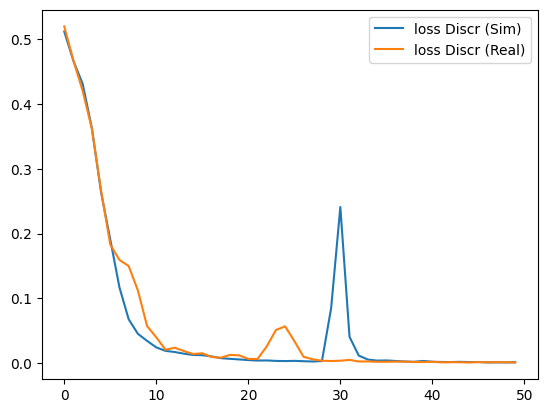

In [ ]:
plt.plot(loss_D_Sim_per_epochs, label = "loss Discr (Sim)")
plt.plot(loss_D_Real_per_epochs, label = "loss Discr (Real)")

plt.legend()

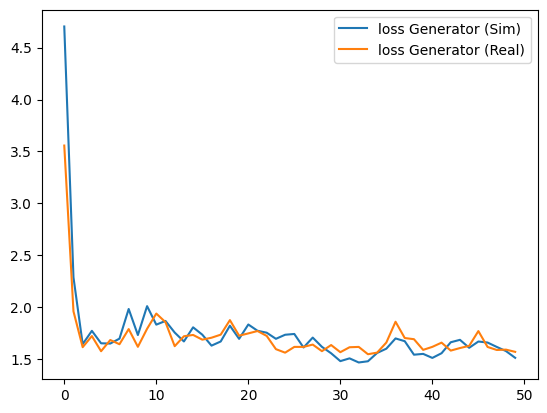

In [ ]:
plt.plot(loss_G_Sim_per_epochs, label = "loss Generator (Sim)")
plt.plot(loss_G_Real_per_epochs, label = "loss Generator (Real)")

plt.legend()

# Test images for our model

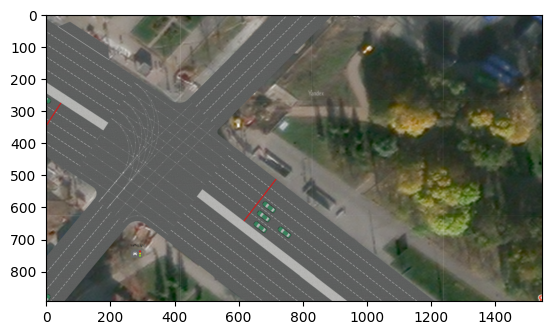

In [ ]:
test_img = np.array(Image.open('/content/drive/MyDrive/CycleGANSim2Real/test.png').convert("RGB"))
test_img = tf.ToTensor()(test_img).to(device)
test_res = gen_SR(test_img )
plt.imshow(plotf(test_img[None, :]))

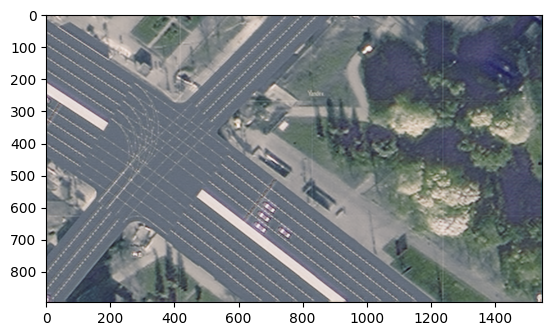

In [ ]:
plt.imshow(plotf(test_res[None, :]))

# Find edges on inputs

In [ ]:
sim_img_tensor, real_img_tensor

In [ ]:
import cv2
sim_img_tensor.shape

torch.Size([1, 3, 400, 600])

In [ ]:
plt.imshow(sim_img_tensor[0].permute(1, 2, 0))

In [ ]:
img = sim_img_tensor[0].permute(1, 2, 0)
print(img.shape)
img = img.numpy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
img_blur = cv2.GaussianBlur(img, (3,3), 0) *255

imgCanny = cv2.Canny(img_blur.astype(np.uint8), 130, 130)
cv2_imshow(imgCanny)